2025-11-12 09:46:04.781572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-12 09:46:04.781713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-12 09:46:04.891984: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


0 null entries found
82004 duplicate entries found


/tmp/ipykernel_36/4196077463.py:525: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_data = df_data.groupby('Label', group_keys=False).apply(


Reduced dataset shape: (223181, 78)
Selected features: 22
Selected features: 21
Epoch 1/250
 59/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6282 - loss: 0.6209

I0000 00:00:1762940810.140603     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7437 - loss: 0.4801 - val_accuracy: 0.9585 - val_loss: 0.1661 - learning_rate: 0.0010
Epoch 2/250
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9468 - loss: 0.2070 - val_accuracy: 0.9696 - val_loss: 0.1257 - learning_rate: 0.0010
Epoch 3/250
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9593 - loss: 0.1636 - val_accuracy: 0.9746 - val_loss: 0.1088 - learning_rate: 0.0010
Epoch 4/250
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9631 - loss: 0.1382 - val_accuracy: 0.9762 - val_loss: 0.0989 - learning_rate: 0.0010
Epoch 5/250
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9643 - loss: 0.1236 - val_accuracy: 0.9764 - val_loss: 0.0919 - learning_rate: 0.0010
Epoch 6/250
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9647 - loss: 0.1129 - val_accuracy: 0.9759 - val_loss: 0.0844 - learning_rate: 0.0010
Epoch 7/250
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9644 - loss: 0.1028 - val_

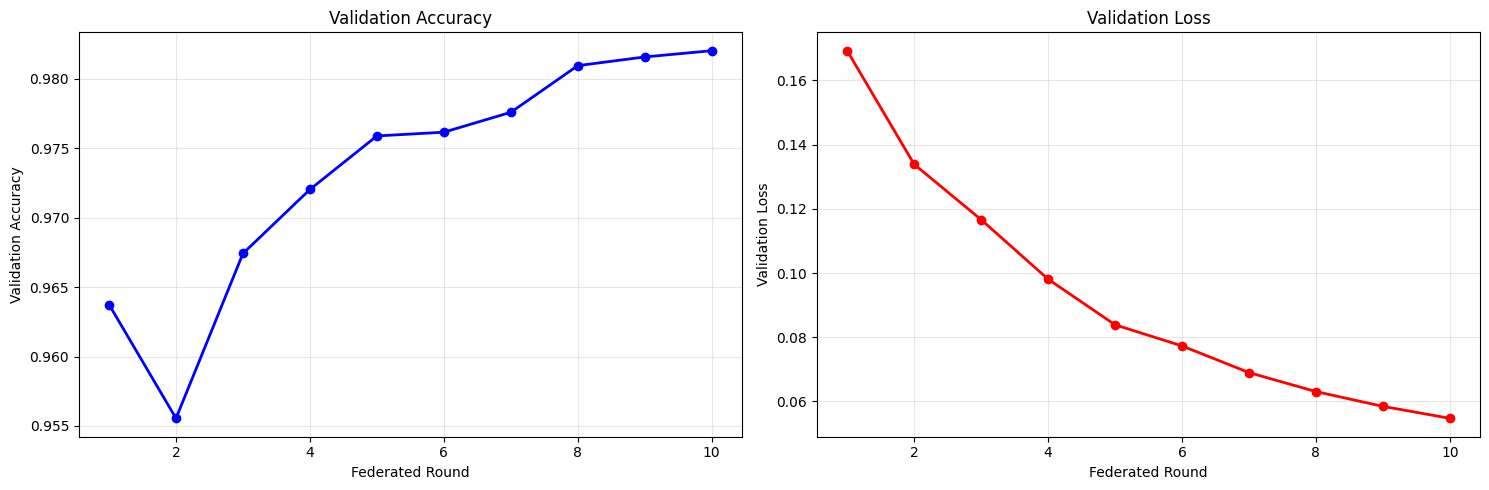

   Metric  Centralized  Federated  Difference
 Accuracy    98.183882  98.058426   -0.125456
Precision    92.125237  92.158742    0.033505
   Recall    96.176704  95.225832   -0.950872
 F1 Score    94.107385  93.667186   -0.440199


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, QuantileTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

import os
import warnings

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.layers import Input, Dense
from keras.initializers import GlorotUniform, HeUniform
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

seed_pi = 314159
np.random.seed(seed_pi)
tf.random.set_seed(seed_pi)

df_data_1 = pd.read_parquet('/kaggle/input/cicids2017/Benign-Monday-no-metadata.parquet')
df_data_2 = pd.read_parquet('/kaggle/input/cicids2017/Botnet-Friday-no-metadata.parquet')
df_data_3 = pd.read_parquet('/kaggle/input/cicids2017/Bruteforce-Tuesday-no-metadata.parquet')
df_data_4 = pd.read_parquet('/kaggle/input/cicids2017/DDoS-Friday-no-metadata.parquet')
df_data_5 = pd.read_parquet('/kaggle/input/cicids2017/DoS-Wednesday-no-metadata.parquet')
df_data_6 = pd.read_parquet('/kaggle/input/cicids2017/Infiltration-Thursday-no-metadata.parquet')
df_data_7 = pd.read_parquet('/kaggle/input/cicids2017/Portscan-Friday-no-metadata.parquet')
df_data_8 = pd.read_parquet('/kaggle/input/cicids2017/WebAttacks-Thursday-no-metadata.parquet')

df_data = pd.concat([df_data_1, df_data_2, df_data_3, df_data_4, 
                     df_data_5, df_data_6, df_data_7, df_data_8], axis=0, ignore_index=True)

null_counts = df_data.isnull().sum()
print(null_counts.sum(), "null entries found")
df_data.dropna(inplace=True)

duplicate_count = df_data.duplicated().sum()
print(duplicate_count, "duplicate entries found")
df_data.drop_duplicates(inplace=True)
df_data.reset_index(drop=True, inplace=True)

df_data = df_data.groupby('Label', group_keys=False).apply(
    lambda x: x.sample(frac=0.1, random_state=seed_pi)
).reset_index(drop=True)

print("Reduced dataset shape:", df_data.shape)

X = df_data.copy()
X = X.drop('Label', axis=1)
y = df_data['Label'].copy()
y_b = y.map({'Benign': 0}).fillna(1)

def extractAllSets(X, y, p_train, p_val, p_test, random_state=seed_pi, shuffle=True):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y,
                                                        test_size=(1.0 - p_train),
                                                        random_state=random_state,
                                                        shuffle=shuffle)
    fraction = p_test / (p_val + p_test)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp,
                                                      test_size=fraction,
                                                      random_state=random_state,
                                                      shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train_b, X_val_b, X_test_b, y_train_b, y_val_b, y_test_b = extractAllSets(
        X, y_b, 0.75, 0.10, 0.15, seed_pi)

original_data_b = [X_train_b, X_val_b, X_test_b, y_train_b, y_val_b, y_test_b]

def get_feature_importances(original_data, clf_params, printing=False):
    X_train, X_val, X_test, y_train, y_val, y_test = original_data
    xgb_clf = XGBClassifier(**clf_params)
    xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    feature_importances = xgb_clf.feature_importances_
    return feature_importances

def select_features_by_threshold(original_data, clf_params, threshold=0.01, printing=False):
    X_train, X_val, X_test, y_train, y_val, y_test = original_data
    feature_importances = get_feature_importances(original_data, clf_params)
    feature_names = X_train.columns
    selected_features = np.where(feature_importances > threshold)[0]
    feature_tuples = [(name, importance) for name, importance in 
        zip(feature_names[selected_features], feature_importances[selected_features])]
    sorted_feature_tuples = sorted(feature_tuples, key=lambda x: x[1], reverse=True)
    sorted_feature_names = [tup[0] for tup in sorted_feature_tuples]
    
    X_train_selected = X_train.loc[:, sorted_feature_names]
    X_val_selected   = X_val.loc[:, sorted_feature_names]
    X_test_selected  = X_test.loc[:, sorted_feature_names]

    print("Selected features:", len(sorted_feature_names))
    
    return X_train_selected, X_val_selected, X_test_selected, sorted_feature_tuples

clf_params_b = dict(
    objective='binary:logistic',
    n_estimators=50,
    eval_metric='logloss',
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    early_stopping_rounds=10,
    random_state=seed_pi)

X_train_selected_b, X_val_selected_b, X_test_selected_b, feature_tuples_b = select_features_by_threshold(
    original_data_b, clf_params=clf_params_b, threshold=0.01, printing=True)

def create_new_features_1(feature_tuples):
    normalizer = Normalizer()
    df_normalized_train = pd.DataFrame(normalizer.fit_transform(X_train_selected_b), 
                                       columns=X_train_selected_b.columns)
    df_normalized_val   = pd.DataFrame(normalizer.transform(X_val_selected_b), 
                                       columns=X_val_selected_b.columns)
    df_normalized_test  = pd.DataFrame(normalizer.transform(X_test_selected_b), 
                                       columns=X_test_selected_b.columns)
    
    feature_names, weights = zip(*feature_tuples)
    df_normalized_train["Combined_Importance_Score"] = df_normalized_train[list(feature_names)].dot(weights)
    df_normalized_val["Combined_Importance_Score"]   = df_normalized_val[list(feature_names)].dot(weights)
    df_normalized_test["Combined_Importance_Score"]  = df_normalized_test[list(feature_names)].dot(weights)
    
    return df_normalized_train, df_normalized_val, df_normalized_test

def create_new_features_2(df):
    df["Packet_Length_Std_Diff"] = df["Bwd Packet Length Std"] - df["Packet Length Std"]
    df["Total_Packets_Diff"] = df["Total Fwd Packets"] - X["Total Backward Packets"]
    return df

def create_new_features_3(df):
    df["Bwd_Fwd_Product"] = df["Bwd Packets/s"] * df["Flow Duration"]
    return df

X_train_selected_b, X_val_selected_b, X_test_selected_b = create_new_features_1(feature_tuples_b)
X_train_selected_b = create_new_features_2(X_train_selected_b)
X_val_selected_b   = create_new_features_2(X_val_selected_b)
X_test_selected_b  = create_new_features_2(X_test_selected_b)
X_train_selected_b = create_new_features_3(X_train_selected_b)
X_val_selected_b   = create_new_features_3(X_val_selected_b)
X_test_selected_b  = create_new_features_3(X_test_selected_b)

selected_data_b = [X_train_selected_b, X_val_selected_b, X_test_selected_b,
                   y_train_b, y_val_b, y_test_b]

X_train_final_b, X_val_final_b, X_test_final_b, feature_tuples_final_b = select_features_by_threshold(
               selected_data_b, clf_params=clf_params_b, threshold=0.01, printing=True)

smote = SMOTE(sampling_strategy=0.5, random_state=seed_pi)
X_train_final_b, y_train_b = smote.fit_resample(X_train_final_b, y_train_b)

def q_transformation(data):
    quantile_transformer = QuantileTransformer(n_quantiles=10**4, output_distribution='uniform')
    data_0_tr = quantile_transformer.fit_transform(data[0])
    data_1_tr = quantile_transformer.transform(data[1])
    data_2_tr = quantile_transformer.transform(data[2])
    return [data_0_tr, data_1_tr, data_2_tr]

final_data_b = [X_train_final_b, X_val_final_b, X_test_final_b, y_train_b, y_val_b, y_test_b]
X_train_b, X_val_b, X_test_b = q_transformation(final_data_b)

input_shape = X_train_b.shape[1]

centralized_model = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(8,  activation='selu', kernel_initializer=HeUniform()),
    Dense(4,  activation='selu', kernel_initializer=HeUniform()),
    Dense(2,  activation='selu', kernel_initializer=HeUniform()),
    Dense(1,  activation='sigmoid', kernel_initializer=GlorotUniform())])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=4,
    min_lr=1e-07,
    verbose=0,
    factor=0.1)

centralized_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

history_centralized = centralized_model.fit(
    x=X_train_b, 
    y=y_train_b, 
    validation_data=(X_val_b, y_val_b),
    epochs=250, 
    batch_size=1024, 
    callbacks=[early_stopping, reduce_lr], 
    verbose=1)

test_loss_c, test_accuracy_c = centralized_model.evaluate(X_test_b, y_test_b, verbose=0)
y_pred_c = centralized_model.predict(X_test_b, verbose=0)
y_pred_labels_c = (y_pred_c > 0.5).astype(int).flatten()

test_precision_c = precision_score(y_test_b, y_pred_labels_c)
test_recall_c = recall_score(y_test_b, y_pred_labels_c)
test_f1_c = f1_score(y_test_b, y_pred_labels_c)

print("Centralized Model Results")
print("Accuracy:", round(test_accuracy_c*100, 2), "%")
print("Precision:", round(test_precision_c*100, 2), "%")
print("Recall:", round(test_recall_c*100, 2), "%")
print("F1 Score:", round(test_f1_c*100, 2), "%")

cm_c = confusion_matrix(y_test_b, y_pred_labels_c)
print("Confusion Matrix:")
print("Predicted Benign | Predicted Malicious")
print("Benign:", cm_c[0][0], cm_c[0][1])
print("Malicious:", cm_c[1][0], cm_c[1][1])

NUM_CLIENTS = 5
FEDERATED_ROUNDS = 10
LOCAL_EPOCHS = 5
BATCH_SIZE = 1024

def partition_data_non_iid(X, y, num_clients, alpha=0.5, random_state=seed_pi):
    np.random.seed(random_state)
    n_samples = len(X)
    
    classes = np.unique(y)
    class_indices = {cls: np.where(y == cls)[0] for cls in classes}
    
    client_data_indices = [[] for _ in range(num_clients)]
    
    for cls in classes:
        cls_idx = class_indices[cls]
        np.random.shuffle(cls_idx)
        
        proportions = np.random.dirichlet([alpha] * num_clients)
        proportions = (np.cumsum(proportions) * len(cls_idx)).astype(int)[:-1]
        cls_splits = np.split(cls_idx, proportions)
        
        for client_id, split in enumerate(cls_splits):
            client_data_indices[client_id].extend(split)
    
    client_data = []
    for client_id, indices in enumerate(client_data_indices):
        indices = np.array(indices)
        np.random.shuffle(indices)
        
        X_client = X[indices]
        y_client = y.iloc[indices].values if isinstance(y, pd.Series) else y[indices]
        
        unique, counts = np.unique(y_client, return_counts=True)
        class_dist = dict(zip(unique, counts))
        benign_pct = (class_dist.get(0, 0) / len(y_client)) * 100
        malicious_pct = (class_dist.get(1, 0) / len(y_client)) * 100
        
        print("Client", client_id + 1, ":", len(X_client), "samples | Benign:", round(benign_pct, 1), "% | Malicious:", round(malicious_pct, 1), "%")
        
        client_data.append((X_client, y_client))
    
    return client_data

client_train_data = partition_data_non_iid(X_train_b, y_train_b, NUM_CLIENTS, alpha=0.5)

def create_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(16, activation='tanh', kernel_initializer=GlorotUniform(seed=seed_pi)),
        Dense(8,  activation='selu', kernel_initializer=HeUniform(seed=seed_pi)),
        Dense(4,  activation='selu', kernel_initializer=HeUniform(seed=seed_pi)),
        Dense(2,  activation='selu', kernel_initializer=HeUniform(seed=seed_pi)),
        Dense(1,  activation='sigmoid', kernel_initializer=GlorotUniform(seed=seed_pi))])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    return model

def federated_averaging(client_weights, client_sizes):
    total_size = sum(client_sizes)
    avg_weights = []
    
    for layer_idx in range(len(client_weights[0])):
        weighted_layer = np.zeros_like(client_weights[0][layer_idx], dtype=np.float64)
        
        for client_id, weights in enumerate(client_weights):
            weight = client_sizes[client_id] / total_size
            weighted_layer += weights[layer_idx] * weight
        
        avg_weights.append(weighted_layer)
    
    return avg_weights

def train_client(model, X_client, y_client, epochs, batch_size):
    history = model.fit(
        X_client, y_client,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        validation_split=0.1)
    
    return model.get_weights(), history

global_model = create_model(input_shape)

round_accuracies = []
round_losses = []

for round_num in range(FEDERATED_ROUNDS):
    print("Round", round_num + 1, "/", FEDERATED_ROUNDS)
    
    client_weights = []
    client_sizes = []
    client_losses = []
    client_accuracies = []
    
    for client_id in range(NUM_CLIENTS):
        client_model = create_model(input_shape)
        client_model.set_weights(global_model.get_weights())
        
        X_client, y_client = client_train_data[client_id]
        
        weights, history = train_client(
            client_model, X_client, y_client, 
            LOCAL_EPOCHS, BATCH_SIZE)
        
        client_weights.append(weights)
        client_sizes.append(len(X_client))
        client_losses.append(history.history['loss'][-1])
        client_accuracies.append(history.history['accuracy'][-1])
        
        print("Client", client_id + 1, ": Loss =", round(client_losses[-1], 4), ", Accuracy =", round(client_accuracies[-1], 4))
    
    aggregated_weights = federated_averaging(client_weights, client_sizes)
    global_model.set_weights(aggregated_weights)
    
    val_loss, val_accuracy = global_model.evaluate(X_val_b, y_val_b, verbose=0)
    round_accuracies.append(val_accuracy)
    round_losses.append(val_loss)
    
    print("Global Model - Val Loss:", round(val_loss, 4), ", Val Accuracy:", round(val_accuracy, 4))
    print("Average Client Loss:", round(np.mean(client_losses), 4), ", Avg Client Accuracy:", round(np.mean(client_accuracies), 4))

test_loss_f, test_accuracy_f = global_model.evaluate(X_test_b, y_test_b, verbose=0)
y_pred_f = global_model.predict(X_test_b, verbose=0)
y_pred_labels_f = (y_pred_f > 0.5).astype(int).flatten()

test_precision_f = precision_score(y_test_b, y_pred_labels_f)
test_recall_f = recall_score(y_test_b, y_pred_labels_f)
test_f1_f = f1_score(y_test_b, y_pred_labels_f)

print("Federated Model Results")
print("Accuracy:", round(test_accuracy_f*100, 2), "%")
print("Precision:", round(test_precision_f*100, 2), "%")
print("Recall:", round(test_recall_f*100, 2), "%")
print("F1 Score:", round(test_f1_f*100, 2), "%")

cm_f = confusion_matrix(y_test_b, y_pred_labels_f)
print("Confusion Matrix:")
print("Predicted Benign | Predicted Malicious")
print("Benign:", cm_f[0][0], cm_f[0][1])
print("Malicious:", cm_f[1][0], cm_f[1][1])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(1, FEDERATED_ROUNDS + 1), round_accuracies, marker='o', linewidth=2, color='blue')
axes[0].set_xlabel('Federated Round')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Validation Accuracy')
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, FEDERATED_ROUNDS + 1), round_losses, marker='o', linewidth=2, color='red')
axes[1].set_xlabel('Federated Round')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Centralized': [test_accuracy_c*100, test_precision_c*100, test_recall_c*100, test_f1_c*100],
    'Federated': [test_accuracy_f*100, test_precision_f*100, test_recall_f*100, test_f1_f*100]
})

comparison_df['Difference'] = comparison_df['Federated'] - comparison_df['Centralized']
print(comparison_df.to_string(index=False))


                 feature  difference  cohens_d  malicious_mean  benign_mean
  Packet_Length_Std_Diff    0.351462  1.580433        0.734547     0.383086
   Bwd Packet Length Min    0.455957  1.562285        0.006060     0.462017
             Fwd IAT Std    0.444566  1.515604        0.706619     0.262054
       Total Fwd Packets    0.303925  1.211548        0.296053     0.599978
           Bwd Packets/s    0.302595  1.184629        0.290415     0.593009
   Bwd Packet Length Std    0.395574  1.126672        0.611462     0.215888
   Fwd Packet Length Min    0.365683  1.116129        0.104299     0.469982
       Subflow Fwd Bytes    0.274280  1.101584        0.309017     0.583298
Fwd Packets Length Total    0.271790  1.093032        0.315132     0.586922
  Total Backward Packets    0.285691  1.088978        0.307757     0.593448
                Idle Max    0.403100  1.086751        0.546617     0.143518
   Fwd Packet Length Max    0.267596  1.059993        0.315873     0.583469
            

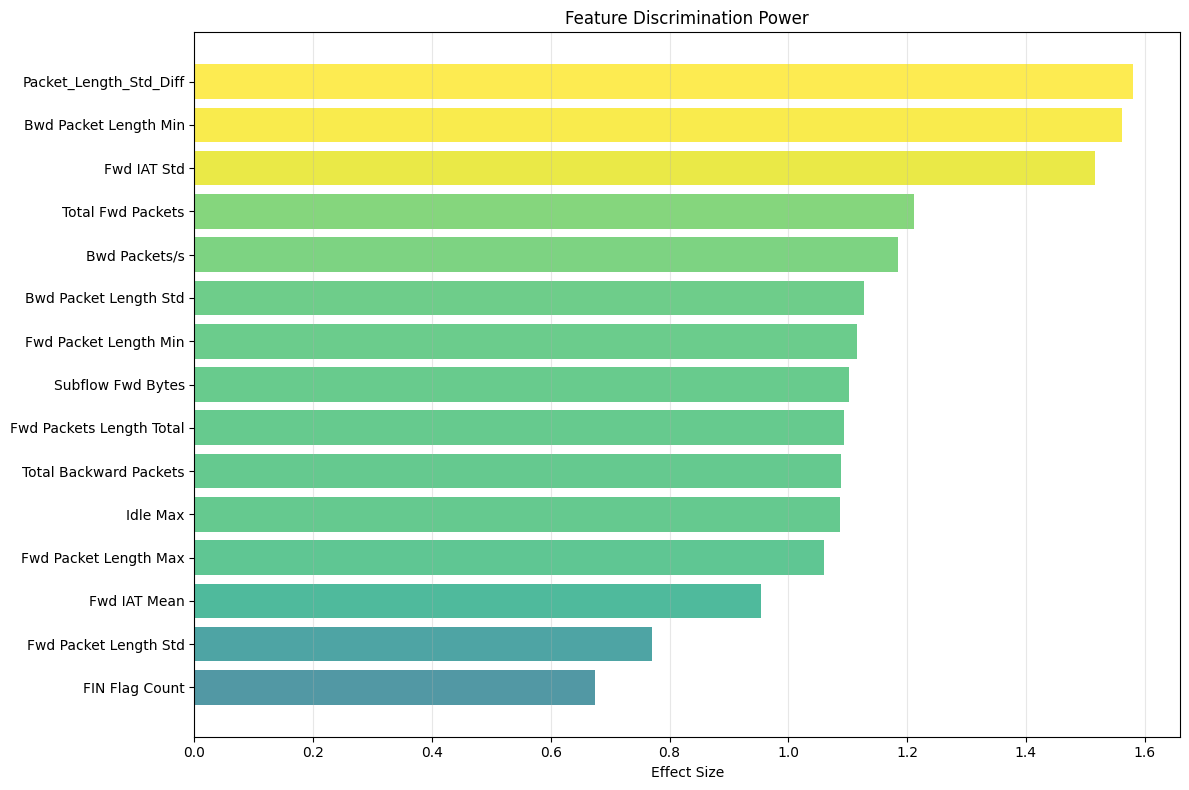

Client 1 (89408 samples, 10.7% malicious)
  1 Bwd Packet Length Min (diff: 0.456285)
  2 Fwd IAT Std (diff: 0.444498)
  3 Idle Max (diff: 0.402938)
  4 Bwd Packet Length Std (diff: 0.396975)
  5 Fwd Packet Length Min (diff: 0.36677)
Client 2 (6477 samples, 11.7% malicious)
  1 Bwd Packet Length Min (diff: 0.448758)
  2 Fwd IAT Std (diff: 0.442613)
  3 Idle Max (diff: 0.398854)
  4 Bwd Packet Length Std (diff: 0.398493)
  5 Fwd Packet Length Min (diff: 0.355823)
Client 3 (62925 samples, 51.8% malicious)
  1 Bwd Packet Length Min (diff: 0.454148)
  2 Fwd IAT Std (diff: 0.444549)
  3 Idle Max (diff: 0.403935)
  4 Bwd Packet Length Std (diff: 0.394824)
  5 Fwd Packet Length Min (diff: 0.366207)
Client 4 (42482 samples, 40.5% malicious)
  1 Bwd Packet Length Min (diff: 0.457372)
  2 Fwd IAT Std (diff: 0.442478)
  3 Idle Max (diff: 0.399295)
  4 Bwd Packet Length Std (diff: 0.398219)
  5 Fwd Packet Length Min (diff: 0.366043)
Client 5 (11930 samples, 91.6% malicious)
  1 Bwd Packet Length Mi

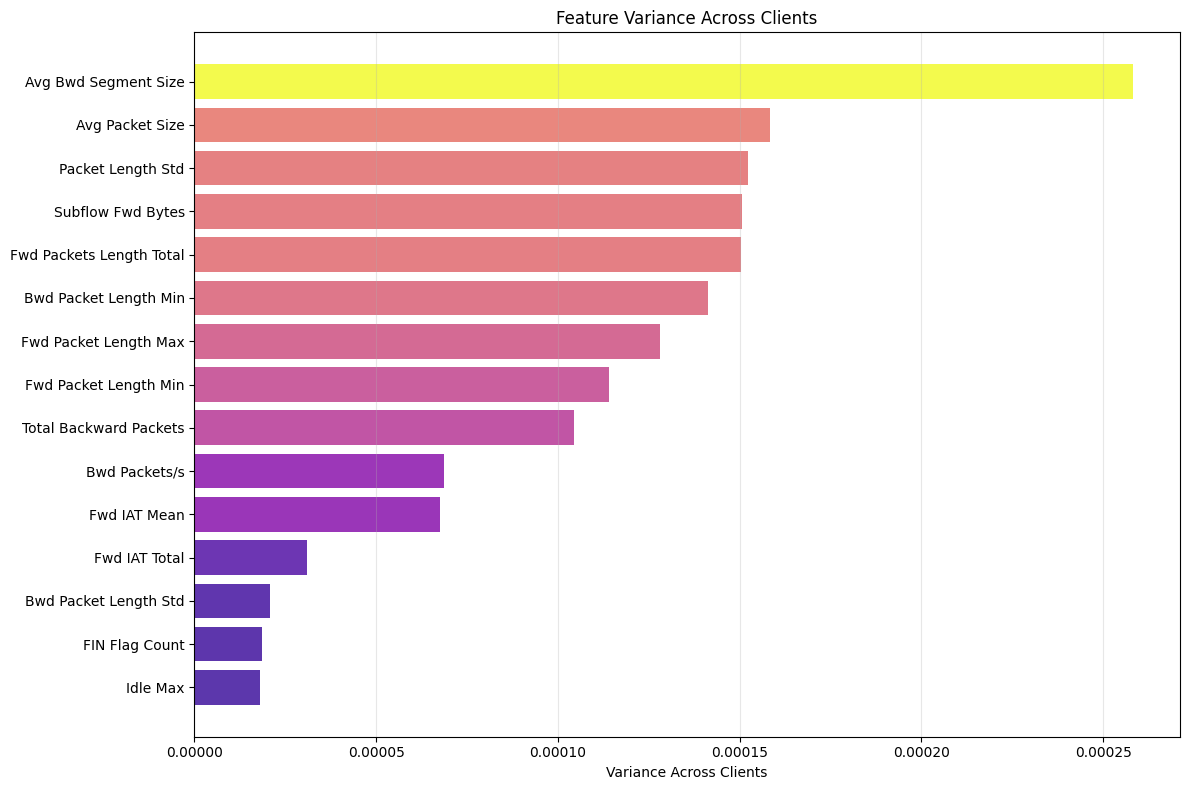

                  Feature  Discrimination_Power  Client_Variance  Combined_Score
   Packet_Length_Std_Diff              1.000000         1.000000        1.000000
   Total Backward Packets              0.987100         0.609133        0.873710
                 Idle Max              0.953919         0.585581        0.843418
              Fwd IAT Std              0.737789         0.579303        0.690243
    Bwd Packet Length Min              0.718655         0.578160        0.676506
            Bwd Packets/s              0.677458         0.542703        0.637032
            Flow Duration              0.669964         0.490193        0.616032
          Avg Packet Size              0.659625         0.435714        0.592452
    Bwd Packet Length Std              0.653546         0.398302        0.576973
            Fwd IAT Total              0.650665         0.257597        0.532744
Combined_Importance_Score              0.649081         0.253140        0.530299
        Total Fwd Packets   

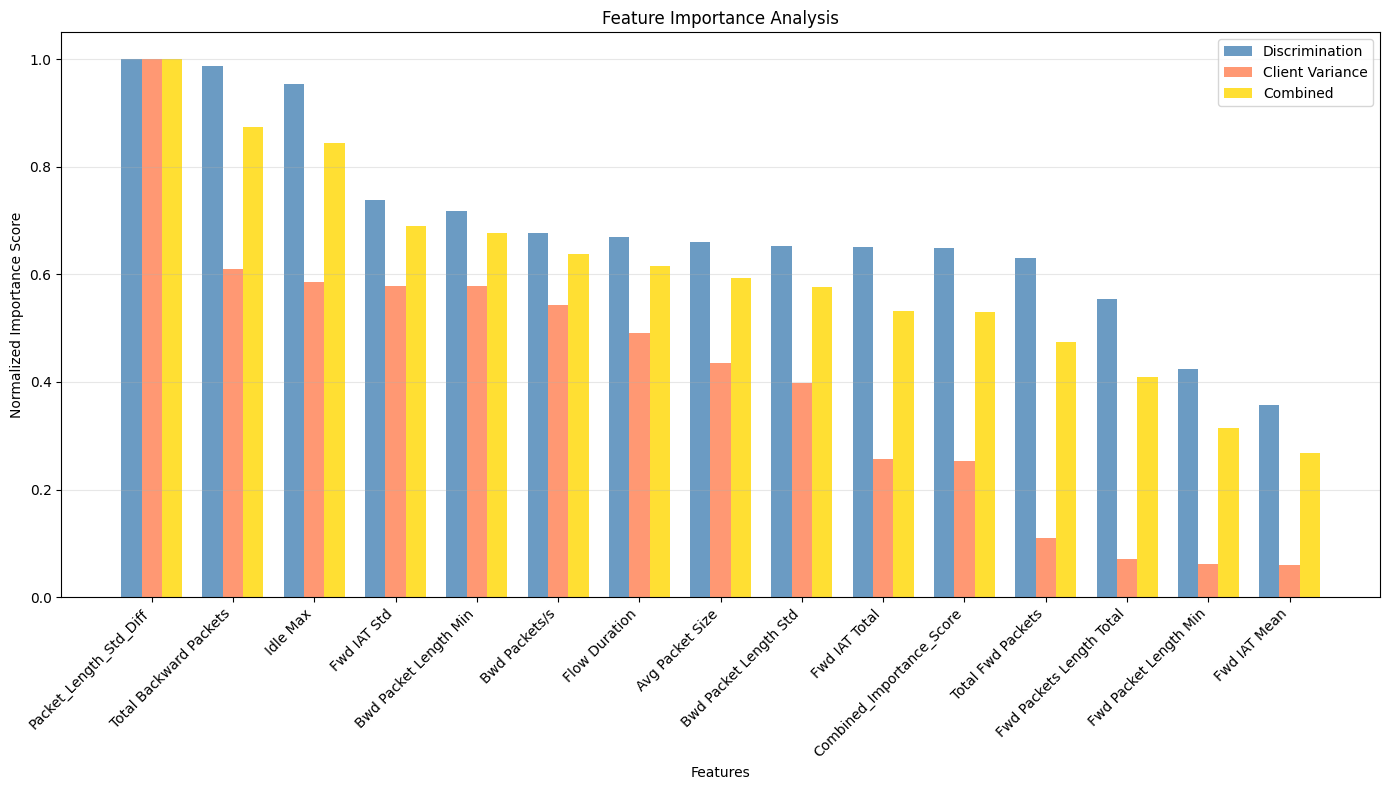


INTERPRETATION:
- Discrimination Power: How well features separate Benign vs Malicious
- Client Variance: How differently features behave across clients (non-IID)
- Combined Score: Overall feature importance (70% discrimination, 30% variance)


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

malicious_mask = y_train_b == 1
benign_mask = y_train_b == 0

malicious_data = X_train_b[malicious_mask]
benign_data = X_train_b[benign_mask]

feature_discrimination = []

for i, feature_name in enumerate(X_train_final_b.columns):
    mal_mean = malicious_data[:, i].mean()
    ben_mean = benign_data[:, i].mean()
    mal_std = malicious_data[:, i].std()
    ben_std = benign_data[:, i].std()
    
    pooled_std = np.sqrt((mal_std**2 + ben_std**2) / 2)
    cohens_d = abs(mal_mean - ben_mean) / (pooled_std + 1e-10)
    
    feature_discrimination.append({
        'feature': feature_name,
        'malicious_mean': mal_mean,
        'benign_mean': ben_mean,
        'difference': abs(mal_mean - ben_mean),
        'cohens_d': cohens_d,
        'malicious_std': mal_std,
        'benign_std': ben_std
    })

discrimination_df = pd.DataFrame(feature_discrimination).sort_values('cohens_d', ascending=False)

print(discrimination_df[['feature', 'difference', 'cohens_d', 'malicious_mean', 'benign_mean']].head(15).to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 8))
top_features = discrimination_df.head(15)

y_pos = np.arange(len(top_features))
colors = plt.cm.viridis(top_features['cohens_d'] / top_features['cohens_d'].max())

ax.barh(y_pos, top_features['cohens_d'], align='center', color=colors, alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel("Effect Size")
ax.set_title('Feature Discrimination Power')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

client_analysis = []

for client_id in range(NUM_CLIENTS):
    X_client, y_client = client_train_data[client_id]
    
    malicious_idx = y_client == 1
    benign_idx = y_client == 0
    
    if malicious_idx.sum() > 0 and benign_idx.sum() > 0:
        malicious_means = X_client[malicious_idx].mean(axis=0)
        benign_means = X_client[benign_idx].mean(axis=0)
        differences = np.abs(malicious_means - benign_means)
        
        client_analysis.append({
            'client_id': client_id + 1,
            'n_samples': len(X_client),
            'pct_malicious': (malicious_idx.sum() / len(y_client)) * 100,
            'feature_differences': differences
        })

for client in client_analysis:
    top_features_idx = np.argsort(client['feature_differences'])[-5:][::-1]
    top_features = X_train_final_b.columns[top_features_idx]
    
    print("Client", client['client_id'], "(" + str(client['n_samples']), "samples,", str(round(client['pct_malicious'], 1)) + "% malicious)")
    for i, feat in enumerate(top_features, 1):
        diff = client['feature_differences'][top_features_idx[i-1]]
        print(" ", i, feat, "(diff:", str(round(diff, 6)) + ")")

all_diffs = np.array([c['feature_differences'] for c in client_analysis])
variance_across_clients = all_diffs.var(axis=0)
mean_across_clients = all_diffs.mean(axis=0)

variance_df = pd.DataFrame({
    'feature': X_train_final_b.columns,
    'variance_across_clients': variance_across_clients,
    'mean_difference': mean_across_clients,
    'coefficient_of_variation': variance_across_clients / (mean_across_clients + 1e-10)
}).sort_values('variance_across_clients', ascending=False)

print(variance_df.head(15).to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 8))
top_variance = variance_df.head(15)

y_pos = np.arange(len(top_variance))
colors = plt.cm.plasma(top_variance['variance_across_clients'] / top_variance['variance_across_clients'].max())

ax.barh(y_pos, top_variance['variance_across_clients'], align='center', color=colors, alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_variance['feature'])
ax.invert_yaxis()
ax.set_xlabel('Variance Across Clients')
ax.set_title('Feature Variance Across Clients')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-10)

combined_df = pd.DataFrame({
    'Feature': X_train_final_b.columns,
    'Discrimination_Power': normalize(discrimination_df['cohens_d'].values),
    'Client_Variance': normalize(variance_df['variance_across_clients'].values)
})

combined_df['Combined_Score'] = (
    combined_df['Discrimination_Power'] * 0.7 + 
    combined_df['Client_Variance'] * 0.3
)

combined_df = combined_df.sort_values('Combined_Score', ascending=False)

print(combined_df.head(15).to_string(index=False))

fig, ax = plt.subplots(figsize=(14, 8))
top_combined = combined_df.head(15)

x = np.arange(len(top_combined))
width = 0.25

ax.bar(x - width, top_combined['Discrimination_Power'], width, 
       label='Discrimination', alpha=0.8, color='steelblue')
ax.bar(x, top_combined['Client_Variance'], width,
       label='Client Variance', alpha=0.8, color='coral')
ax.bar(x + width, top_combined['Combined_Score'], width,
       label='Combined', alpha=0.8, color='gold')

ax.set_xlabel('Features')
ax.set_ylabel('Normalized Importance Score')
ax.set_title('Feature Importance Analysis')
ax.set_xticks(x)
ax.set_xticklabels(top_combined['Feature'], rotation=45, ha='right')
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

combined_df.to_csv('federated_xai_results.csv', index=False)


print("\nINTERPRETATION:")
print("- Discrimination Power: How well features separate Benign vs Malicious")
print("- Client Variance: How differently features behave across clients (non-IID)")
print("- Combined Score: Overall feature importance (70% discrimination, 30% variance)")


In [ ]:
!pip install lime

Instance 1 - Centralized
True: Benign
Predicted: Benign (89.79%)


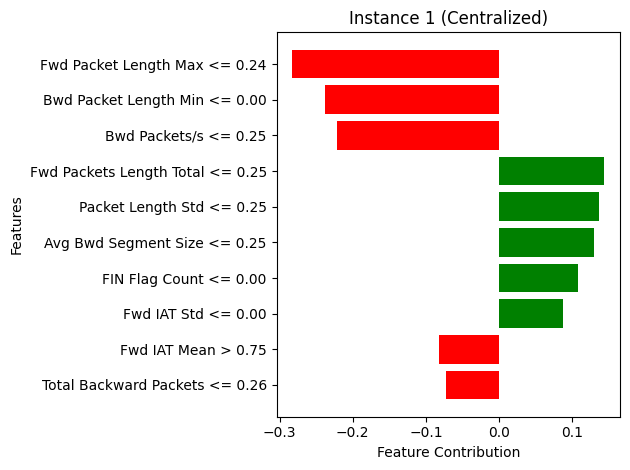

                            Feature    Weight
0     Fwd Packet Length Max <= 0.24 -0.282913
1     Bwd Packet Length Min <= 0.00 -0.237721
2             Bwd Packets/s <= 0.25 -0.221255
3  Fwd Packets Length Total <= 0.25  0.144077
4         Packet Length Std <= 0.25  0.136266
5      Avg Bwd Segment Size <= 0.25  0.129504
6            FIN Flag Count <= 0.00  0.108492
7               Fwd IAT Std <= 0.00  0.087220
8               Fwd IAT Mean > 0.75 -0.082337
9    Total Backward Packets <= 0.26 -0.072201

Instance 2 - Centralized
True: Benign
Predicted: Benign (100.0%)


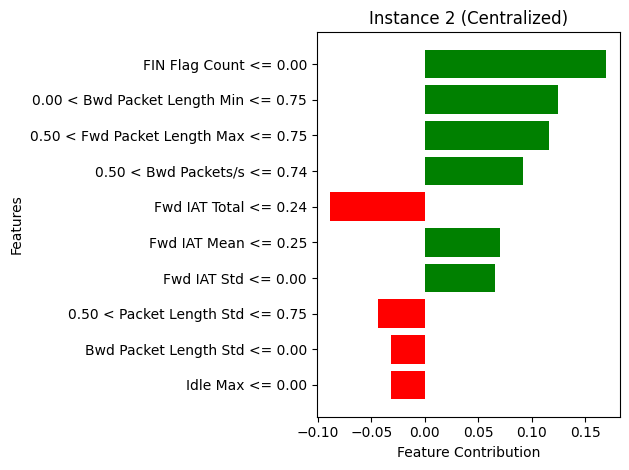

                                Feature    Weight
0                FIN Flag Count <= 0.00  0.169801
1  0.00 < Bwd Packet Length Min <= 0.75  0.124968
2  0.50 < Fwd Packet Length Max <= 0.75  0.116157
3          0.50 < Bwd Packets/s <= 0.74  0.091547
4                 Fwd IAT Total <= 0.24 -0.088319
5                  Fwd IAT Mean <= 0.25  0.070519
6                   Fwd IAT Std <= 0.00  0.066038
7      0.50 < Packet Length Std <= 0.75 -0.044082
8         Bwd Packet Length Std <= 0.00 -0.031735
9                      Idle Max <= 0.00 -0.031388

Instance 3 - Centralized
True: Malicious
Predicted: Malicious (95.56%)


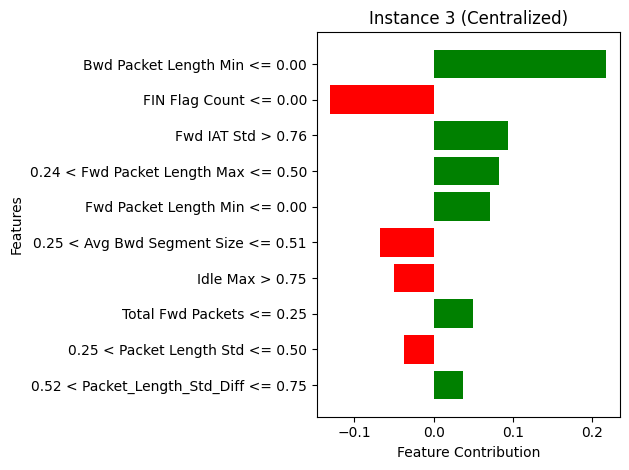

                                 Feature    Weight
0          Bwd Packet Length Min <= 0.00  0.217534
1                 FIN Flag Count <= 0.00 -0.130295
2                     Fwd IAT Std > 0.76  0.093055
3   0.24 < Fwd Packet Length Max <= 0.50  0.082438
4          Fwd Packet Length Min <= 0.00  0.070333
5    0.25 < Avg Bwd Segment Size <= 0.51 -0.067572
6                        Idle Max > 0.75 -0.049904
7              Total Fwd Packets <= 0.25  0.048939
8       0.25 < Packet Length Std <= 0.50 -0.037678
9  0.52 < Packet_Length_Std_Diff <= 0.75  0.036816

Instance 4 - Centralized
True: Malicious
Predicted: Malicious (100.0%)


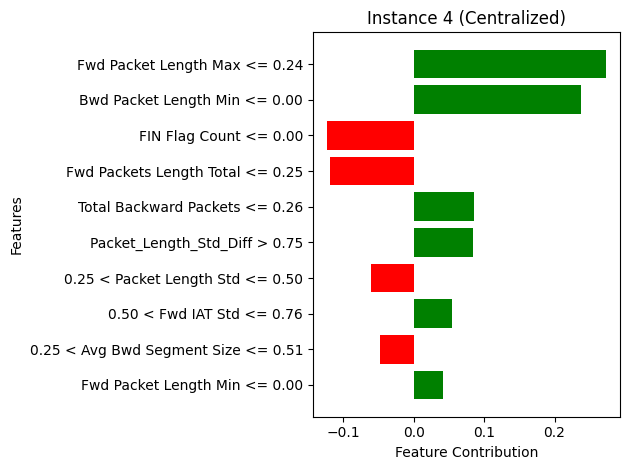

                               Feature    Weight
0        Fwd Packet Length Max <= 0.24  0.273213
1        Bwd Packet Length Min <= 0.00  0.238094
2               FIN Flag Count <= 0.00 -0.123795
3     Fwd Packets Length Total <= 0.25 -0.119605
4       Total Backward Packets <= 0.26  0.085571
5        Packet_Length_Std_Diff > 0.75  0.084322
6     0.25 < Packet Length Std <= 0.50 -0.060667
7           0.50 < Fwd IAT Std <= 0.76  0.054148
8  0.25 < Avg Bwd Segment Size <= 0.51 -0.048713
9        Fwd Packet Length Min <= 0.00  0.041820

Instance 5 - Centralized
True: Benign
Predicted: Malicious (83.47%)


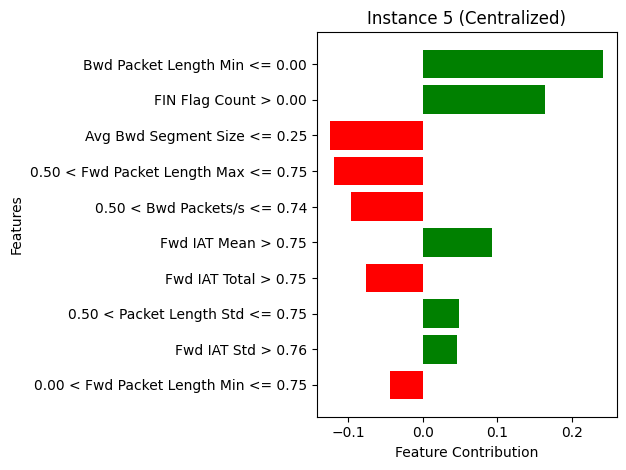

                                Feature    Weight
0         Bwd Packet Length Min <= 0.00  0.241337
1                 FIN Flag Count > 0.00  0.163601
2          Avg Bwd Segment Size <= 0.25 -0.123821
3  0.50 < Fwd Packet Length Max <= 0.75 -0.118674
4          0.50 < Bwd Packets/s <= 0.74 -0.096396
5                   Fwd IAT Mean > 0.75  0.093245
6                  Fwd IAT Total > 0.75 -0.075802
7      0.50 < Packet Length Std <= 0.75  0.048402
8                    Fwd IAT Std > 0.76  0.045345
9  0.00 < Fwd Packet Length Min <= 0.75 -0.043701

Instance 1 - Federated
True: Benign
Predicted: Benign (94.34%)


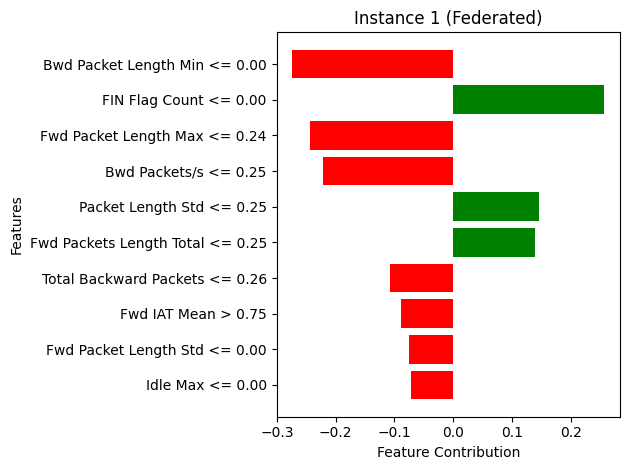

                            Feature    Weight
0     Bwd Packet Length Min <= 0.00 -0.273970
1            FIN Flag Count <= 0.00  0.257430
2     Fwd Packet Length Max <= 0.24 -0.243688
3             Bwd Packets/s <= 0.25 -0.222100
4         Packet Length Std <= 0.25  0.146759
5  Fwd Packets Length Total <= 0.25  0.138633
6    Total Backward Packets <= 0.26 -0.107161
7               Fwd IAT Mean > 0.75 -0.088473
8     Fwd Packet Length Std <= 0.00 -0.075504
9                  Idle Max <= 0.00 -0.072151

Instance 2 - Federated
True: Benign
Predicted: Benign (99.98%)


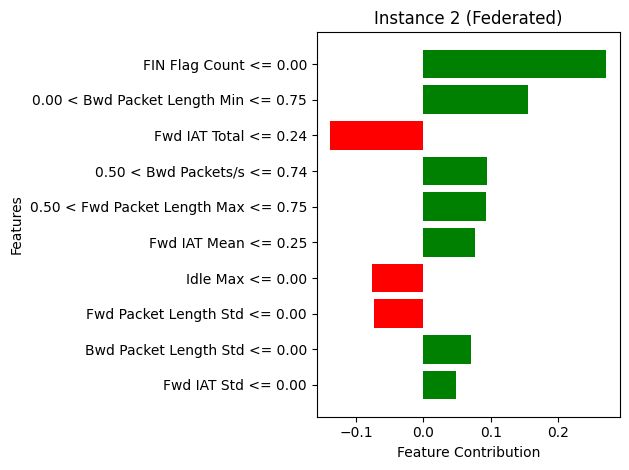

                                Feature    Weight
0                FIN Flag Count <= 0.00  0.271300
1  0.00 < Bwd Packet Length Min <= 0.75  0.155980
2                 Fwd IAT Total <= 0.24 -0.137686
3          0.50 < Bwd Packets/s <= 0.74  0.094036
4  0.50 < Fwd Packet Length Max <= 0.75  0.093150
5                  Fwd IAT Mean <= 0.25  0.076879
6                      Idle Max <= 0.00 -0.076257
7         Fwd Packet Length Std <= 0.00 -0.073546
8         Bwd Packet Length Std <= 0.00  0.071072
9                   Fwd IAT Std <= 0.00  0.047898

Instance 3 - Federated
True: Malicious
Predicted: Malicious (96.49%)


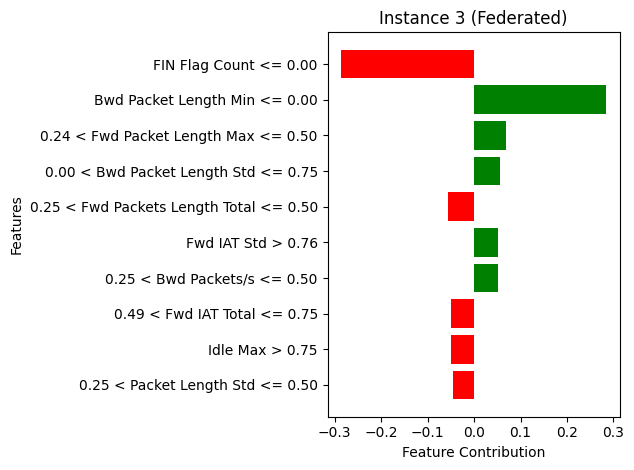

                                   Feature    Weight
0                   FIN Flag Count <= 0.00 -0.286746
1            Bwd Packet Length Min <= 0.00  0.284944
2     0.24 < Fwd Packet Length Max <= 0.50  0.068262
3     0.00 < Bwd Packet Length Std <= 0.75  0.056845
4  0.25 < Fwd Packets Length Total <= 0.50 -0.055472
5                       Fwd IAT Std > 0.76  0.050838
6             0.25 < Bwd Packets/s <= 0.50  0.050761
7             0.49 < Fwd IAT Total <= 0.75 -0.049134
8                          Idle Max > 0.75 -0.048902
9         0.25 < Packet Length Std <= 0.50 -0.046348

Instance 4 - Federated
True: Malicious
Predicted: Malicious (99.7%)


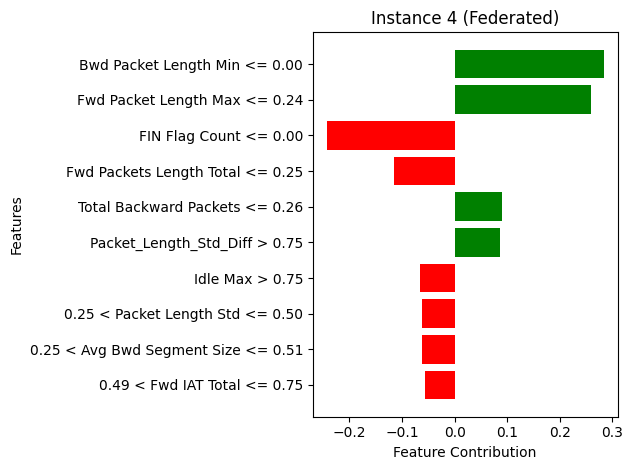

                               Feature    Weight
0        Bwd Packet Length Min <= 0.00  0.283555
1        Fwd Packet Length Max <= 0.24  0.259707
2               FIN Flag Count <= 0.00 -0.243393
3     Fwd Packets Length Total <= 0.25 -0.114720
4       Total Backward Packets <= 0.26  0.090637
5        Packet_Length_Std_Diff > 0.75  0.086363
6                      Idle Max > 0.75 -0.065886
7     0.25 < Packet Length Std <= 0.50 -0.061967
8  0.25 < Avg Bwd Segment Size <= 0.51 -0.061059
9         0.49 < Fwd IAT Total <= 0.75 -0.056488

Instance 5 - Federated
True: Benign
Predicted: Malicious (80.24%)


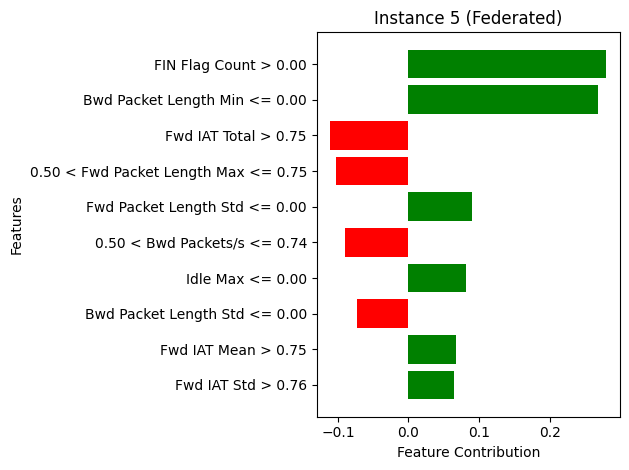

                                Feature    Weight
0                 FIN Flag Count > 0.00  0.279930
1         Bwd Packet Length Min <= 0.00  0.268754
2                  Fwd IAT Total > 0.75 -0.110507
3  0.50 < Fwd Packet Length Max <= 0.75 -0.103306
4         Fwd Packet Length Std <= 0.00  0.090102
5          0.50 < Bwd Packets/s <= 0.74 -0.089863
6                      Idle Max <= 0.00  0.082013
7         Bwd Packet Length Std <= 0.00 -0.072286
8                   Fwd IAT Mean > 0.75  0.066640
9                    Fwd IAT Std > 0.76  0.063754



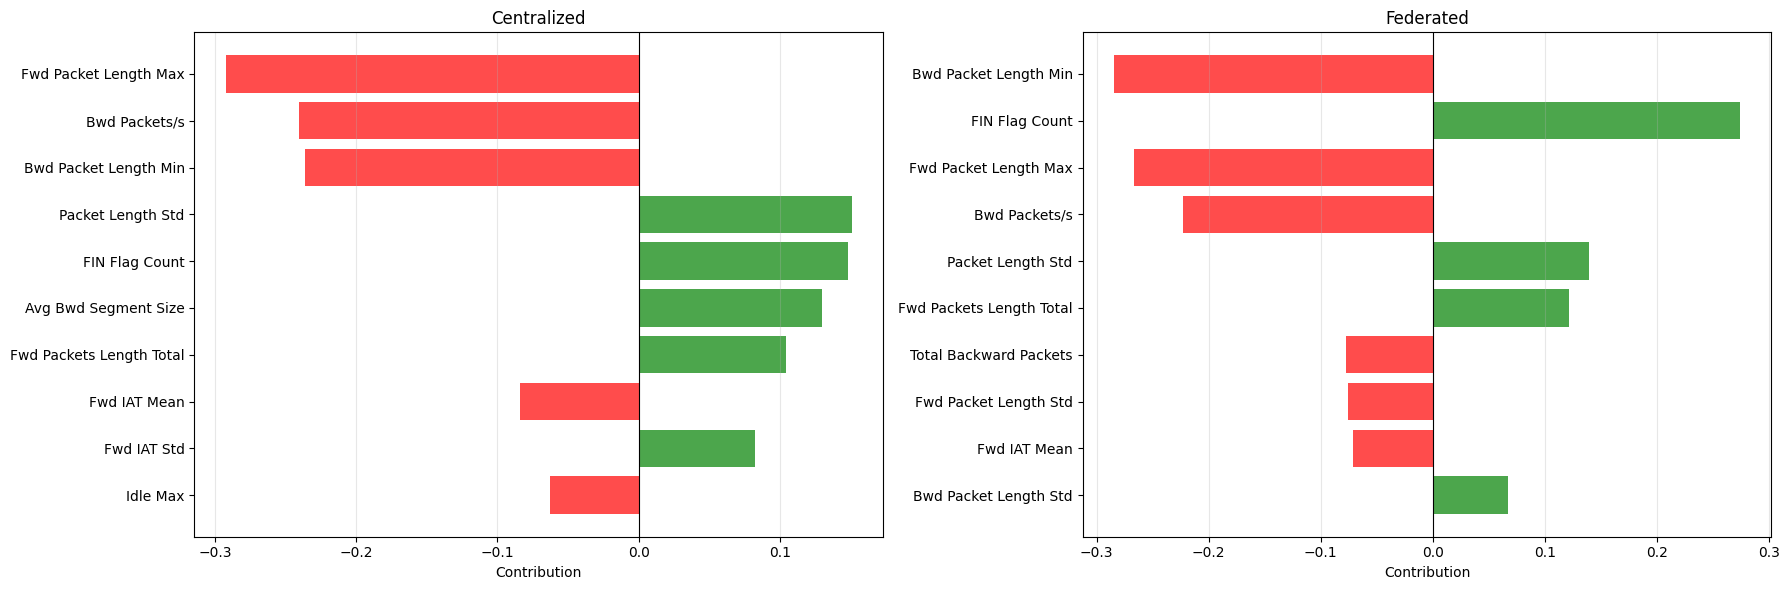

 Rank          Centralized Feature  Centralized Importance            Federated Feature  Federated Importance
    1        Fwd Packet Length Max                0.260337               FIN Flag Count              0.276438
    2        Bwd Packet Length Min                0.233840        Bwd Packet Length Min              0.266431
    3                Bwd Packets/s                0.210683        Fwd Packet Length Max              0.240862
    4            Packet Length Std                0.140588                Bwd Packets/s              0.204548
    5         Avg Bwd Segment Size                0.134931 0.00 < Bwd Packet Length Min              0.158586
    6 0.00 < Bwd Packet Length Min                0.134610            Packet Length Std              0.147122
    7               FIN Flag Count                0.127660     Fwd Packets Length Total              0.129494
    8     Fwd Packets Length Total                0.125464                Fwd IAT Total              0.113756
    9 0.50

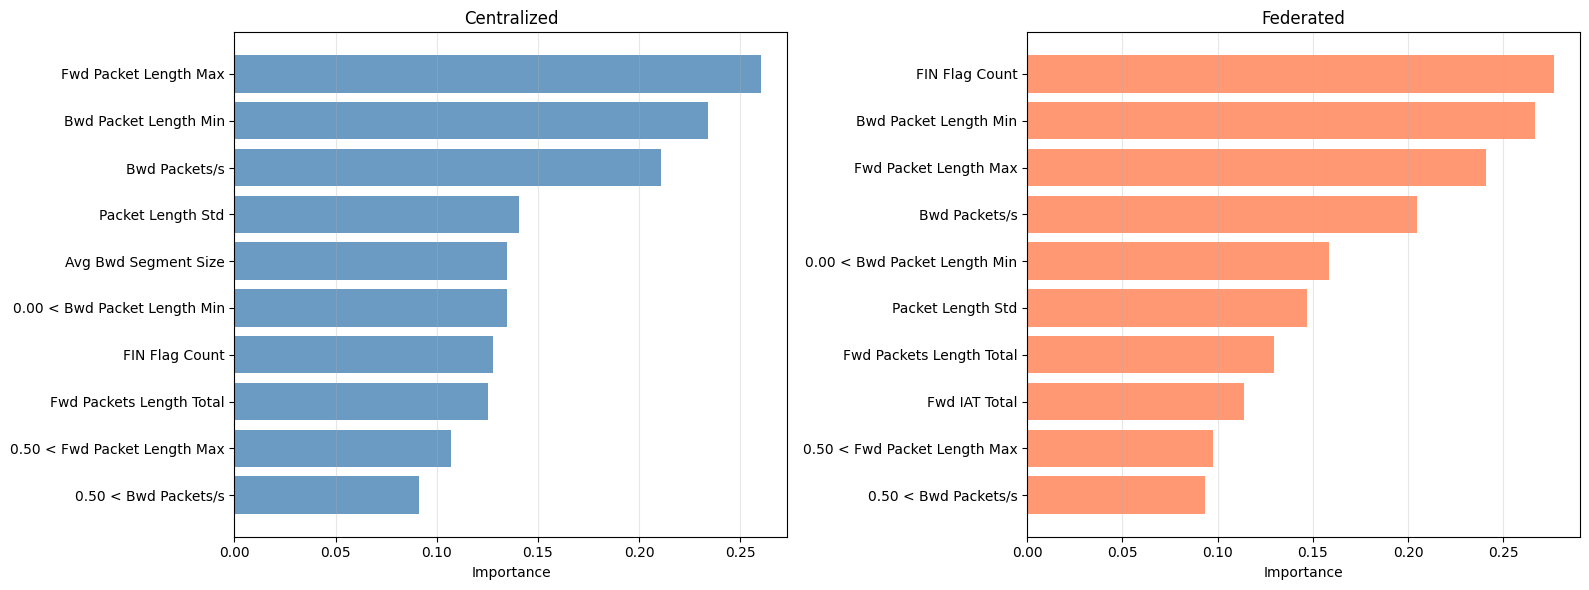

In [4]:
import lime
import lime.lime_tabular

feature_names = X_train_final_b.columns.tolist()

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_b,
    feature_names=feature_names,
    class_names=['Benign', 'Malicious'],
    mode='classification',
    random_state=seed_pi
)

def centralized_predict_proba(X):
    predictions = centralized_model.predict(X, verbose=0)
    proba_class_0 = 1 - predictions.flatten()
    proba_class_1 = predictions.flatten()
    return np.column_stack([proba_class_0, proba_class_1])

def federated_predict_proba(X):
    predictions = global_model.predict(X, verbose=0)
    proba_class_0 = 1 - predictions.flatten()
    proba_class_1 = predictions.flatten()
    return np.column_stack([proba_class_0, proba_class_1])

benign_correct = np.where((y_test_b == 0) & (y_pred_labels_c == 0))[0][:2]
malicious_correct = np.where((y_test_b == 1) & (y_pred_labels_c == 1))[0][:2]
misclassified = np.where(y_test_b.values != y_pred_labels_c)[0][:1]

explain_indices = np.concatenate([benign_correct, malicious_correct, misclassified])

for idx, test_idx in enumerate(explain_indices):
    instance = X_test_b[test_idx]
    true_label = y_test_b.iloc[test_idx]
    pred_proba = centralized_predict_proba(instance.reshape(1, -1))[0]
    pred_label = int(pred_proba[1] > 0.5)
    
    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=centralized_predict_proba,
        num_features=10,
        top_labels=2
    )
    
    print("Instance", idx + 1, "- Centralized")
    print("True:", "Malicious" if true_label == 1 else "Benign")
    print("Predicted:", "Malicious" if pred_label == 1 else "Benign", "(" + str(round(pred_proba[pred_label]*100, 2)) + "%)")
    
    fig = exp.as_pyplot_figure(label=pred_label)
    plt.title("Instance " + str(idx + 1) + " (Centralized)")
    plt.xlabel("Feature Contribution")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()
    
    explanation_list = exp.as_list(label=pred_label)
    exp_df = pd.DataFrame(explanation_list, columns=['Feature', 'Weight'])
    exp_df['Abs Weight'] = exp_df['Weight'].abs()
    exp_df = exp_df.sort_values('Abs Weight', ascending=False).reset_index(drop=True)
    print(exp_df[['Feature', 'Weight']].head(10).to_string(index=True))
    print()

for idx, test_idx in enumerate(explain_indices):
    instance = X_test_b[test_idx]
    true_label = y_test_b.iloc[test_idx]
    pred_proba = federated_predict_proba(instance.reshape(1, -1))[0]
    pred_label = int(pred_proba[1] > 0.5)
    
    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=federated_predict_proba,
        num_features=10,
        top_labels=2
    )
    
    print("Instance", idx + 1, "- Federated")
    print("True:", "Malicious" if true_label == 1 else "Benign")
    print("Predicted:", "Malicious" if pred_label == 1 else "Benign", "(" + str(round(pred_proba[pred_label]*100, 2)) + "%)")
    
    fig = exp.as_pyplot_figure(label=pred_label)
    plt.title("Instance " + str(idx + 1) + " (Federated)")
    plt.xlabel("Feature Contribution")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()
    
    explanation_list = exp.as_list(label=pred_label)
    exp_df = pd.DataFrame(explanation_list, columns=['Feature', 'Weight'])
    exp_df['Abs Weight'] = exp_df['Weight'].abs()
    exp_df = exp_df.sort_values('Abs Weight', ascending=False).reset_index(drop=True)
    print(exp_df[['Feature', 'Weight']].head(10).to_string(index=True))
    print()

comparison_idx = explain_indices[0]
instance = X_test_b[comparison_idx]
true_label = y_test_b.iloc[comparison_idx]

exp_c = explainer.explain_instance(
    data_row=instance,
    predict_fn=centralized_predict_proba,
    num_features=10,
    top_labels=2
)

exp_f = explainer.explain_instance(
    data_row=instance,
    predict_fn=federated_predict_proba,
    num_features=10,
    top_labels=2
)

pred_c = centralized_predict_proba(instance.reshape(1, -1))[0]
pred_f = federated_predict_proba(instance.reshape(1, -1))[0]
pred_label_c = int(pred_c[1] > 0.5)
pred_label_f = int(pred_f[1] > 0.5)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

exp_list_c = exp_c.as_list(label=pred_label_c)
features_c = [x[0].split('<=')[0].split('>')[0].strip() for x in exp_list_c]
weights_c = [x[1] for x in exp_list_c]
colors_c = ['green' if w > 0 else 'red' for w in weights_c]

axes[0].barh(range(len(features_c)), weights_c, color=colors_c, alpha=0.7)
axes[0].set_yticks(range(len(features_c)))
axes[0].set_yticklabels(features_c)
axes[0].set_xlabel("Contribution")
axes[0].set_title("Centralized")
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

exp_list_f = exp_f.as_list(label=pred_label_f)
features_f = [x[0].split('<=')[0].split('>')[0].strip() for x in exp_list_f]
weights_f = [x[1] for x in exp_list_f]
colors_f = ['green' if w > 0 else 'red' for w in weights_f]

axes[1].barh(range(len(features_f)), weights_f, color=colors_f, alpha=0.7)
axes[1].set_yticks(range(len(features_f)))
axes[1].set_yticklabels(features_f)
axes[1].set_xlabel("Contribution")
axes[1].set_title("Federated")
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

num_samples = 50
sample_indices = np.random.choice(len(X_test_b), num_samples, replace=False)

centralized_feature_importance = {}
federated_feature_importance = {}

for idx in sample_indices:
    instance = X_test_b[idx]
    
    exp_c = explainer.explain_instance(
        data_row=instance,
        predict_fn=centralized_predict_proba,
        num_features=len(feature_names)
    )
    
    for feature, weight in exp_c.as_list():
        feat_name = feature.split('<=')[0].split('>')[0].strip()
        if feat_name not in centralized_feature_importance:
            centralized_feature_importance[feat_name] = []
        centralized_feature_importance[feat_name].append(abs(weight))
    
    exp_f = explainer.explain_instance(
        data_row=instance,
        predict_fn=federated_predict_proba,
        num_features=len(feature_names)
    )
    
    for feature, weight in exp_f.as_list():
        feat_name = feature.split('<=')[0].split('>')[0].strip()
        if feat_name not in federated_feature_importance:
            federated_feature_importance[feat_name] = []
        federated_feature_importance[feat_name].append(abs(weight))

centralized_mean = {feat: np.mean(weights) for feat, weights in centralized_feature_importance.items()}
federated_mean = {feat: np.mean(weights) for feat, weights in federated_feature_importance.items()}

centralized_sorted = sorted(centralized_mean.items(), key=lambda x: x[1], reverse=True)[:10]
federated_sorted = sorted(federated_mean.items(), key=lambda x: x[1], reverse=True)[:10]

comparison_data = []
for i in range(10):
    c_feat, c_imp = centralized_sorted[i] if i < len(centralized_sorted) else ("N/A", 0)
    f_feat, f_imp = federated_sorted[i] if i < len(federated_sorted) else ("N/A", 0)
    comparison_data.append({
        'Rank': i + 1,
        'Centralized Feature': c_feat,
        'Centralized Importance': c_imp,
        'Federated Feature': f_feat,
        'Federated Importance': f_imp
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

c_features = [x[0] for x in centralized_sorted]
c_importance = [x[1] for x in centralized_sorted]
axes[0].barh(range(len(c_features)), c_importance, color='steelblue', alpha=0.8)
axes[0].set_yticks(range(len(c_features)))
axes[0].set_yticklabels(c_features)
axes[0].set_xlabel("Importance")
axes[0].set_title("Centralized")
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

f_features = [x[0] for x in federated_sorted]
f_importance = [x[1] for x in federated_sorted]
axes[1].barh(range(len(f_features)), f_importance, color='coral', alpha=0.8)
axes[1].set_yticks(range(len(f_features)))
axes[1].set_yticklabels(f_features)
axes[1].set_xlabel("Importance")
axes[1].set_title("Federated")
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
